In [26]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model 
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, log_loss, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

import cv2
from imutils.contours import sort_contours
import imutils
import seaborn as sns
sns.set_style('darkgrid')

In [27]:
directory = r''

In [52]:
Name=[]
for file in os.listdir(directory):
    if file!='.directory':
        Name+=[file]
print(Name)
print(len(Name))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub', 'x', 'y', 'z']
19


In [102]:
N=[]
for i in range(len(Name)):
    N+=[i]
    
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name))
#print(normal_mapping)
reverse_mapping[10] = "+"
reverse_mapping[11] = "."
reverse_mapping[12] = "/"
reverse_mapping[13] = "="
reverse_mapping[14] = "*"
reverse_mapping[15] = "-"
for key, value in reverse_mapping.items():
    print(key, ' : ', value)
def mapper(value):
    return reverse_mapping[value]


0  :  0
1  :  1
2  :  2
3  :  3
4  :  4
5  :  5
6  :  6
7  :  7
8  :  8
9  :  9
10  :  +
11  :  .
12  :  /
13  :  =
14  :  *
15  :  -
16  :  x
17  :  y
18  :  z


In [28]:
filepaths=[]
labels=[]
classes=[]
for file in os.listdir(directory):
    classpath=os.path.join(directory, file)
    if os.path.isdir(classpath): 
        classes.append(file)
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            if os.path.isfile(fpath):
                filepaths.append(fpath)
                labels.append(file)


fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series (labels, name='labels')

df=pd.concat([fseries, Lseries], axis=1)
print (df['labels'].value_counts())
df


sub    655
eq     634
dec    624
div    618
add    596
0      595
6      581
mul    577
1      562
8      554
9      547
3      541
7      533
4      526
x      452
5      433
2      433
y      399
z      212
Name: labels, dtype: int64


,filepaths,labels
0,C:\Users\Muhammad Haris\dataset\0\0CdBlhLw.png,0
1,C:\Users\Muhammad Haris\dataset\0\10014.jpg,0
2,C:\Users\Muhammad Haris\dataset\0\1058.jpg,0
3,C:\Users\Muhammad Haris\dataset\0\10679.jpg,0
4,C:\Users\Muhammad Haris\dataset\0\10825.jpg,0
...,...,...
10067,C:\Users\Muhammad Haris\dataset\z\YT8qmWIN.png,z
10068,C:\Users\Muhammad Haris\dataset\z\yySeSeTY.png,z
10069,C:\Users\Muhammad Haris\dataset\z\zdNZMhet.png,z
10070,C:\Users\Muhammad Haris\dataset\z\zNV8tKj2.png,z


In [29]:
train_split=.9
test_split=.05
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state = 42)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=42)


In [30]:
def scalar(img):
    return img/127.5-1
gen=ImageDataGenerator(preprocessing_function=scalar)

In [31]:
train_gen=gen.flow_from_dataframe(train_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)
test_gen=gen.flow_from_dataframe(test_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)
valid_gen=gen.flow_from_dataframe(valid_df, x_col= 'filepaths', y_col='labels', target_size=(128,128), class_mode='categorical',
                                  color_mode='rgb', shuffle=False)

Found 9063 validated image filenames belonging to 19 classes.
Found 504 validated image filenames belonging to 19 classes.
Found 504 validated image filenames belonging to 19 classes.


C:\anaconda\envs\tensorflow\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [32]:
base_model=tf.keras.applications.MobileNetV2( include_top=False, input_shape=(128,128,3), pooling='max', weights='imagenet') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu', kernel_initializer= tf.keras.initializers.GlorotUniform(seed=123))(x)
x=Dropout(rate=.3, seed=123)(x)         
output=Dense(len(classes), activation='softmax',kernel_initializer=tf.keras.initializers.GlorotUniform(seed=123))(x)

In [33]:
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])  
estop=tf.keras.callbacks.EarlyStopping( monitor="val_loss",  patience=4, verbose=1,restore_best_weights=True)
rlronp=tf.keras.callbacks.ReduceLROnPlateau(  monitor="val_loss",factor=0.5, patience=1, verbose=1)

In [34]:
history=model.fit(x=train_gen,  epochs=12, verbose=1, callbacks=[estop, rlronp],  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/12
284/284 [==============================] - 606s 2s/step - loss: 9.7909 - accuracy: 0.9422 - val_loss: 4.1360 - val_accuracy: 0.9107
Epoch 2/12
284/284 [==============================] - 604s 2s/step - loss: 1.8008 - accuracy: 0.9966 - val_loss: 1.2527 - val_accuracy: 0.9345
Epoch 3/12
284/284 [==============================] - 612s 2s/step - loss: 0.5995 - accuracy: 0.9994 - val_loss: 0.6654 - val_accuracy: 0.9762
Epoch 4/12
284/284 [==============================] - 613s 2s/step - loss: 0.3750 - accuracy: 0.9996 - val_loss: 0.4831 - val_accuracy: 0.9901
Epoch 5/12
284/284 [==============================] - 654s 2s/step - loss: 0.3022 - accuracy: 0.9999 - val_loss: 0.3678 - val_accuracy: 0.9921
Epoch 6/12
284/284 [==============================] - 663s 2s/step - loss: 0.2648 - accuracy: 0.9999 - val_loss: 0.2823 - val_accuracy: 0.9921
Epoch 7/12
284/284 [==============================] - 631s 2s/step - loss: 0.2384 - accuracy: 0.9999 - val_loss: 0.2429 - val_accuracy: 0.9960

In [61]:
image=load_img(r'F:\itu\sem5\AI\peeraject\test19.jpg',target_size=(128,128))
image = img_to_array(image)
image = scalar(image)
print(image.shape)
prediction_image= np.expand_dims(image, axis=0)
prediction_image.shape

(128, 128, 3)


(1, 128, 128, 3)

In [130]:
pred=model.predict(prediction_image)
value=np.argmax(pred)
ans = mapper(value)
print(f"the predicted value is {ans}")

the predicted value is 3


In [1]:
pred

NameError: name 'pred' is not defined

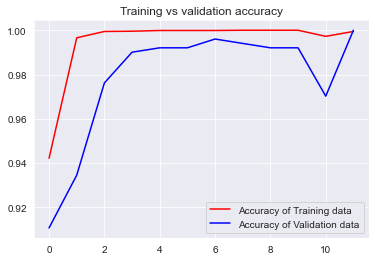

<Figure size 432x288 with 0 Axes>

In [105]:
get_acc = history.history['accuracy']
value_acc = history.history['val_accuracy']
get_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

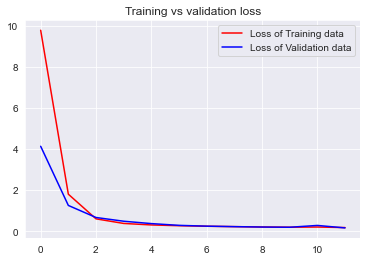

<Figure size 432x288 with 0 Axes>

In [106]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [100]:
preds=model.predict(test_gen)
y_pred=[]
y_true=[]
for i, p in enumerate(preds):
    y_pred.append(np.argmax(p))
    y_true.append(test_gen.labels[i])
y_pred=np.array(y_pred)
y_true=np.array(y_true)
cm = confusion_matrix(y_true, y_pred )

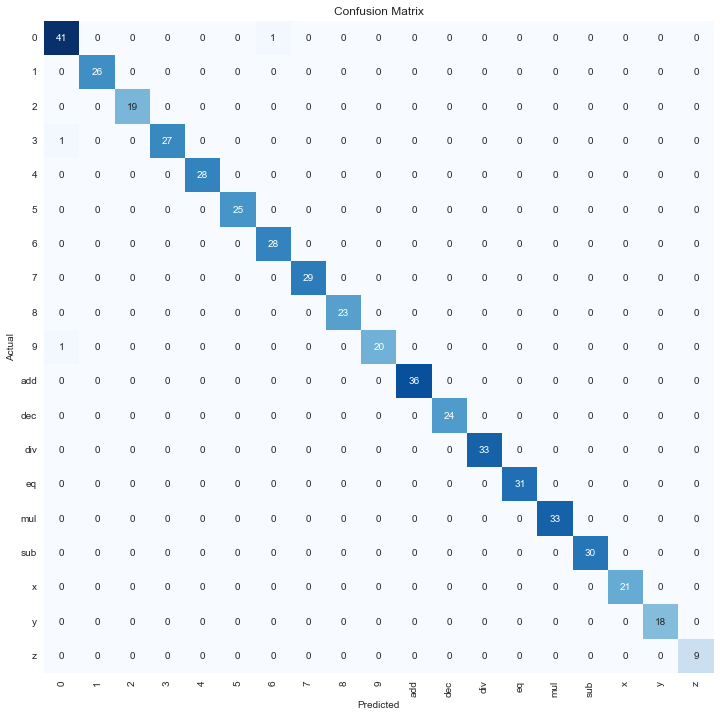

In [103]:
length = 19
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, normal_mapping, rotation= 90)
plt.yticks(np.arange(length)+.5, normal_mapping, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [123]:
def prediction(img):
    img = cv2.resize(img,(128, 128))
    img = cv2.GaussianBlur(img, (5,5), 0)
    plt.imshow(img)
    norm_image=img/255
    norm_image = norm_image.reshape((norm_image.shape[0], norm_image.shape[1], 3))
    case = np.asarray([norm_image])
    pred = model.predict(case)
    value=np.argmax(pred)
    move_name=mapper(value)
    return format(move_name)

In [124]:
def element_extractor_from_image(path,x_inc,y_inc,w_inc,h_inc,thres_val):
    image = cv2.imread(path,0)
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(rgb, (5,5), 0)
    # perform edge detection, find contours in the edge map, and sort the
    # resulting contours from left-to-right
    edged = cv2.Canny(blurred, 30, 150)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    chars=[]
    for c in cnts:

        (x, y, w, h) = cv2.boundingRect(c)
        x = x - x_inc
        y= y- y_inc
        w = w+ w_inc
        h= h+ h_inc
        if w*h>thres_val:

            roi = rgb[y:y + h, x:x + w]
            chars.append(prediction(roi))
            cv2.rectangle(image, (x, y), ((x + w), (y + h)), (0, 255, 0), 2)
    plt.imshow(image)
    print("= ",end="")
    for char in chars:
        print(f"{char} ",end="")

= 7 + 3 

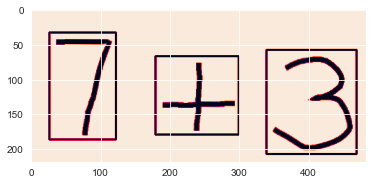

In [125]:
element_extractor_from_image(r"F:\itu\sem5\AI\peeraject\test1.jpg",10,10,15,15,1200)

= 7 x + 3 

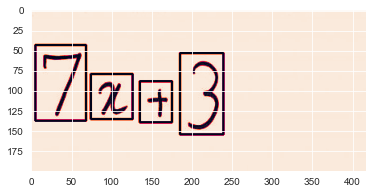

In [126]:
element_extractor_from_image(r"F:\itu\sem5\AI\peeraject\test5.jpg",10,10,15,15,1200)

= 4 * 1 2 

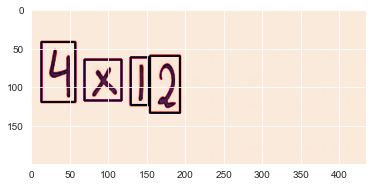

In [127]:
element_extractor_from_image(r"F:\itu\sem5\AI\peeraject\test7.jpg",10,10,15,15,1200)

= 3 

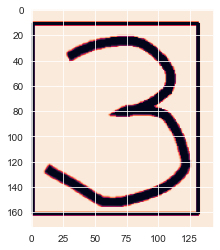

In [128]:
element_extractor_from_image(r"F:\itu\sem5\AI\peeraject\test19.jpg",10,10,15,15,1200)